In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

current_path = sys.path[0]
sys.path.append(current_path[:current_path.find('defi-measurement')] + "liquidity-distribution-history")

In [14]:
import os
from pool_state import v3Pool
import numpy as np
import matplotlib.pyplot as plt

import json

import pandas as pd
from prisma import Prisma


from dotenv import load_dotenv


load_dotenv(override=True)

True

In [4]:
postgres_uri = os.getenv("POSTGRES_URI")

assert postgres_uri is not None, "Connection string to Postgres is not set"

In [5]:
pool_symbols = json.load(open("../addresses/pool_tokens.json", "r"))

# Take out the 10 first pools of the dictionary
pool_symbols = {k: pool_symbols[k] for k in list(pool_symbols)[:10]}

In [6]:
client = Prisma()
await client.connect()

print(f"{await client.swap.count():,}")

341,772


In [7]:
swaps_v3 = await client.swap.find_many()
swap_df = pd.DataFrame([swap.dict() for swap in swaps_v3])

# Filter out only USDC/WETH swaps
swap_df.address = swap_df.address.str.lower()
swap_df = swap_df[swap_df.address.isin(pool_symbols.keys())]

swap_df.amount0 = swap_df.amount0.astype(float)
swap_df.amount1 = swap_df.amount1.astype(float)

print(f"{swap_df.block_number.nunique():,} blocks from {swap_df.block_timestamp.min()} to {swap_df.block_timestamp.max()}")


38,012 blocks from 2023-06-16 22:24:47+00:00 to 2023-06-25 04:11:59+00:00


In [8]:
swapcounts = swap_df.groupby(['block_number', 'address']).count().transaction_hash.sort_values(ascending=False)

swapcounts.head()

block_number  address                                   
17497512      0x11b815efb8f581194ae79006d24e0d814b7697f6    17
17524683      0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640    14
17524685      0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640    13
17543285      0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640    13
17514294      0x11b815efb8f581194ae79006d24e0d814b7697f6    12
Name: transaction_hash, dtype: int64

In [9]:
print(f'More than 3 swaps: {(swapcounts > 3).sum():,} / {swapcounts.shape[0]:,} ({(swapcounts > 3).sum() / swapcounts.shape[0]:.2%})')
print(f'More than 4 swaps: {(swapcounts > 4).sum():,} / {swapcounts.shape[0]:,} ({(swapcounts > 4).sum() / swapcounts.shape[0]:.2%})')

More than 3 swaps: 1,047 / 59,608 (1.76%)
More than 4 swaps: 344 / 59,608 (0.58%)


In [10]:
# Start with block and pool with the most swaps
block_number = int(swapcounts.index.get_level_values(0).values[0])
pool_address = str(swapcounts.index.get_level_values(1)[0])

pool_info = pool_symbols[pool_address]
swap_block = swap_df[(swap_df.block_number == block_number) & (swap_df.address == pool_address)]

print(f'{swap_block.shape[0]:,} swaps in block {block_number:,} for pool {pool_info["name"]}')

tokens = [pool_info['token0'], pool_info['token1']]

swap_block.head()

17 swaps in block 17,497,512 for pool WETH-USDT


,transaction_hash,block_timestamp,block_number,transaction_index,log_index,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,address,from_address,to_address,from_mempool
22733,0xf5701e37d0319ec85054cb088355f27c0b6d28f7fcb9...,2023-06-17 05:41:35+00:00,17497512,1,14,0x8011D6C888214b3aEA276A6D9d893578D8B25B03,0x9Db9e0e53058C89e5B94e29621a205198648425B,1.282645e+20,-2.245331e+11,3314561352866350763091239,7802376149685400398,-201646,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x8011D6C888214b3aEA276A6D9d893578D8B25B03,0x9Db9e0e53058C89e5B94e29621a205198648425B,False
22740,0x5492bc41528fb10b280440676f46b9db7b773ff2dc47...,2023-06-17 05:41:35+00:00,17497512,6,38,0xD050E0A4838D74769228B49dFf97241b4Ef3805d,0xD050E0A4838D74769228B49dFf97241b4Ef3805d,2.922289e+19,-5.111294e+10,3314042333467144456315156,7802376149685400398,-201649,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xD050E0A4838D74769228B49dFf97241b4Ef3805d,0xD050E0A4838D74769228B49dFf97241b4Ef3805d,False
22741,0x97d6e48959951732a30894cc06d3e584fe259ef57ca2...,2023-06-17 05:41:35+00:00,17497512,7,42,0x000000000dFDe7deaF24138722987c9a6991e2D4,0x000000000dFDe7deaF24138722987c9a6991e2D4,-1.712178e+20,3.000000e+11,3317079505511325909817257,7838670566871509933,-201631,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x000000000dFDe7deaF24138722987c9a6991e2D4,0x000000000dFDe7deaF24138722987c9a6991e2D4,False
22743,0xc4d84cb7e210476e52739102afb4dbf670bbcd47312f...,2023-06-17 05:41:35+00:00,17497512,9,51,0x507888e987257a8DdE6F8AFa46375CEfe2CbF504,0x0d4a11d5EEaaC28EC3F61d100daF4d40471f1852,3.284093e+19,-5.752739e+10,3316498056207501433008234,7838670566871509933,-201634,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x507888e987257a8DdE6F8AFa46375CEfe2CbF504,0x0d4a11d5EEaaC28EC3F61d100daF4d40471f1852,False
22750,0x6b308df264240819e184316779164662c768a5a31800...,2023-06-17 05:41:35+00:00,17497512,16,81,0x000000000035B5e5ad9019092C665357240f594e,0x06da0fd433C1A5d7a4faa01111c044910A184553,8.736978e+18,-1.530115e+10,3316343402156208399735313,7838670566871509933,-201635,0x11b815efb8f581194ae79006d24e0d814b7697f6,0x000000000035B5e5ad9019092C665357240f594e,0x06da0fd433C1A5d7a4faa01111c044910A184553,False


### 1. Historical Liquidity Distribution / Market Depth
* Useful when investors want to manually investigate liquidity distribution in history
* Current implementation: 
    - Input: as_of (can be intra-block)
    - Output: liquidity at each tick
* Quick iteration:
    - Input: time_range, frequency
    - Output: dataframe of liquidity distribution at each point in time + gif displaying liquidity dynamics


In [ ]:
pool_address = "0x4e0924d3a751be199c426d52fb1f2337fa96f736"
block_number = 17_576_169

In [11]:
print(f"""
pool_add              = "{pool_address}"
block_number          = {block_number:_}
""")


pool_add              = "0x11b815efb8f581194ae79006d24e0d814b7697f6"
block_number          = 17_497_512



ticks       -8.872700e+05
liquidity    3.411646e+06
px           3.401887e+50
Name: 0, dtype: float64

In [ ]:
%%time
########### INPUT BLOCK ###############
transaction_index     = 0
display_price_lower   = 0.9
display_price_upper   = 1.1
#######################################

as_of = block_number + transaction_index / 1e4
# pool = v3Pool(pool_address, initialize=False, database_url=postgres_uri)
pool = v3Pool(
    pool_address,
    connStr=postgres_uri,
    initialize=False,
    load_data=True,
    update=False,
)

x, y = pool.createLiq(as_of)
x, y = np.array(x), np.array(y)
# px = pool.getPriceAt(as_of)

TypeError: 'v3Pool' object is not subscriptable

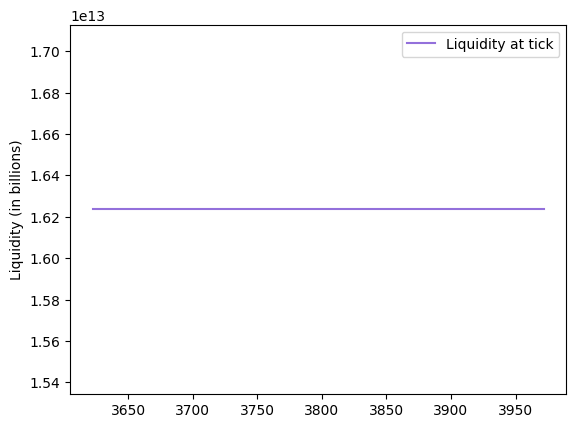

In [46]:

liq_df = pd.DataFrame(x, columns=["ticks"])
liq_df["liquidity"] = y
liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12


# Find upper and lower price bounds

liq_df = liq_df.set_index("px").sort_index()
liq_df = liq_df.assign(cum_liq=liq_df.liquidity.cumsum())

total_liq = liq_df.liquidity.sum()

liq_df = liq_df.assign(cum_liq_pct=liq_df.cum_liq / total_liq)

liq_95 = liq_df[(liq_df.cum_liq_pct > 0.025) & (liq_df.cum_liq_pct < 0.975)]

display_price_lower = liq_95.index.min()
display_price_upper = liq_95.index.max()

plot_df = liq_df[(liq_df.index < display_price_upper) & (liq_df.index > display_price_lower)]
# plot_df = liq_df.set_index("px")

fig, ax = plt.subplots()

ax.plot(plot_df['liquidity'], label="Liquidity at tick", color='mediumpurple')
# ax.axvline((1 / px ** 2) * 1e12, color = 'black', linestyle = "--")
ax.legend()
ax.set_ylabel("Liquidity (in billions)")
ax.set_xlabel(f"Price ({
ax.set_title('Liquidity Distribution as of block number {}'.format(as_of))

KeyError: "None of ['px'] are in the columns"

In [ ]:

# get min and max tick
%%time
########### INPUT BLOCK ###############


swapParams            = {'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
                         'input': 1.26241e+21,
                         'gasFee': True,
                         'as_of': block_number + transaction_index / 1e4}
    
swaps_params = []

for i, (amount0, amount1) in swap_block[['amount0', 'amount1']].iterrows():
    if amount0 > 0:
        amount_in = amount0
        token_in = tokens[0]
    else:
        amount_in = amount1
        token_in = tokens[1]

    swaps_params.append({'tokenIn': token_in, 'input': amount_in, 'gasFee': True})


#######################################

pool = v3Pool(
    pool_address=pool_address,
    database_url=postgres_uri,
    initialize=False,
)

block_results = []

sqrt_P = pool.getPriceAt(block_number)

for i, swap_param in enumerate(swaps_params):
    output, heur = pool.swapIn({**swap_param, 'as_of': block_number + i / 1e4, 'givenPrice': sqrt_P})

    summ = {
        'total_output': output,
        'totalFee': heur[0],
        'crossed_ticks': heur[1], 
        'liquidity_in_range': heur[2], 
        'sqrt_P': heur[3], 
        'sqrtP_next': heur[4], 
        'inRangeTest': heur[5], 
        'swapInMinusFee': heur[6], 
        'zeroForOne': heur[7], 
        'gas_fee': heur[8]
    }

    sqrt_P = heur[3]

    block_results.append({
        'output': output,
        **summ,
    })

print('tx details summary: ')
print(pd.Series(summ).to_string())

In [51]:
pd.DataFrame(block_results)

,output,total_output,totalFee,crossed_ticks,liquidity_in_range,sqrt_P,sqrtP_next,inRangeTest,swapInMinusFee,zeroForOne,gas_fee
0,2112595365876010844160,2112595365876010844160,7085565506945648951296,19304,7.902378e+14,2.403297e-02,1.544536e-06,{},1.594887e+22,1.416405e+25,True
1,12172049565604,12172049565604,7085565506945648951296,2042,1.232422e+10,1.544536e-06,5.563889e-07,{},3.497054e+20,1.416405e+25,True
2,2673999650442,2673999650442,7085565506945649999872,988,1.232422e+10,5.563889e-07,3.393092e-07,{},1.066788e+22,1.416405e+25,True
3,1173044104727,1173044104727,7085565506945648951296,658,1.232422e+10,3.393092e-07,2.440796e-07,{},1.457202e+22,1.416405e+25,True
4,658896423148,658896423148,7085565506945648951296,493,1.232422e+10,2.440796e-07,1.905893e-07,{},2.358995e+22,1.416405e+25,True
5,422013966198,422013966198,7085565506945648951296,396,1.232422e+10,1.905893e-07,1.563295e-07,{},5.262941e+21,1.416405e+25,True
6,293411216345,293411216345,7085565506945648951296,329,1.232422e+10,1.563295e-07,1.325099e-07,{},3.285775e+22,1.416405e+25,True
7,215820702897,215820702897,7085565506945648951296,283,1.232422e+10,1.325099e-07,1.149893e-07,{},9.306206e+21,1.416405e+25,True
8,165413360723,165413360723,7085565506945648951296,247,1.232422e+10,1.149893e-07,1.015608e-07,{},2.938765e+22,1.416405e+25,True
9,130819176969,130819176969,7085565506945648951296,220,1.232422e+10,1.015608e-07,9.094068e-08,{},1.048777e+22,1.416405e+25,True
